In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import AgglomerativeClustering
import math
from datetime import datetime
from sklearn.metrics import adjusted_rand_score, pairwise_distances
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore")

# Attribute Weighting

In [2]:
def exp_fit(x, a, t, c):    #defining a decaying exponential function
    y = a * np.exp(-x / t) + c
    return y

In [3]:
def calc_params(data, num_bins=15, div=4, is_plot=False):    #getting parameters like characteristic length and weights of each attribute
    N, F = data.shape
    scale = np.zeros(F)     # stores the characteristic length of all attributes
    weight = np.zeros(F)
    aa = np.zeros(F)
    cc = np.zeros(F)
    inits = np.zeros((F, 3))

    d_max = np.zeros(F)

    if is_plot:     # storing data for plotting
        li_bin_edges = []
        li_hists = []
        li_xs = []
        li_ys = []

    for l in range(F):

        x1 = data[:, l]
        x1 = np.array(x1).reshape(N, 1)

        # Absolute pairwise diifferences
        dx = cdist(x1, x1, metric='minkowski', p=1)
        out = dx[np.tril_indices(N, k = -1)]

        hist, bin_edges = np.histogram(out, bins=num_bins) # generating a histogram

        x_fit = bin_edges[:num_bins]    # independent variables

        # initialization for curve fitting. In case of poor fitting, try with different values of div
        init = [ hist[0], bin_edges[-1] / div, hist[-1] ]

        fit_ = curve_fit(exp_fit, x_fit, hist, p0=init, maxfev=10000)   # exponential decaying curve fitting

        a, t, c = fit_[0][0], fit_[0][1], fit_[0][2]    # storing fitted parameters

        aa[l] = a
        cc[l] = c
        inits[l][0] = init[0]   # storing initial parameters
        inits[l][1] = init[1]
        inits[l][2] = init[2]

        d_max[l] = np.max(out)
        scale[l] = t / d_max[l]

        if is_plot: # plotting the histogram and fitted curve
            x_ = np.arange(x_fit[0], bin_edges[-1] + x_fit[1], x_fit[1] / 20).astype('float')
            fit_eq = a * np.exp( - x_ / t ) + c
            pos_ind = np.where(fit_eq >= 0)

            li_xs.append(x_[pos_ind])
            li_ys.append(fit_eq[pos_ind])
            li_bin_edges.append(bin_edges)
            li_hists.append(hist)

    weight = scale / scale.sum()

    if is_plot:
        for l in range(F):
            bin_edges = li_bin_edges[l]
            hist = li_hists[l]
            xs = li_xs[l]
            ys = li_ys[l]


            plt.figure(figsize=(7, 4))
            plt.bar(bin_edges[:num_bins], hist, alpha = 0.5, align = 'edge', width = (bin_edges[1] - bin_edges[0]))
            plt.plot(xs, ys, c = 'C3', linewidth=5, label=r'$t_{norm}^{' + str(l + 1) +'} = '+str(round(scale[l], 4)) + ',w^{' + str(l + 1) + '} = '+str(round(weight[l], 4)) + '$')
            plt.xticks(bin_edges[::1], np.round(bin_edges, 3)[::1], fontsize=10, fontweight='bold')
            plt.yticks(fontsize=10, fontweight='bold')
            plt.legend(prop={'size':10}, frameon=False)

            plt.title("feature-" + str(l + 1))

            # plt.savefig('fig_curve_fit_f' + str(_i + 1)  + '.eps', format='eps')
            # plt.savefig('fig_curve_fit_example.eps', format='eps', dpi=100)
            # plt.savefig('fig_curve_fit_f' + str(_i + 1)  + '.pgf', format='pgf')
            plt.show()

    return scale, weight, d_max, aa, cc, inits

# Test

Loading dataset

In [4]:
file_path = 'sonar.txt'
df = pd.read_csv(file_path, sep='\t', header=None)
X, lab = np.array(df.iloc[:, :-1]), np.array(df.iloc[:, -1])
K = len(set(lab))
N, f = X.shape
N, f, K

(208, 60, 2)

Pre-computing required parameters and weights

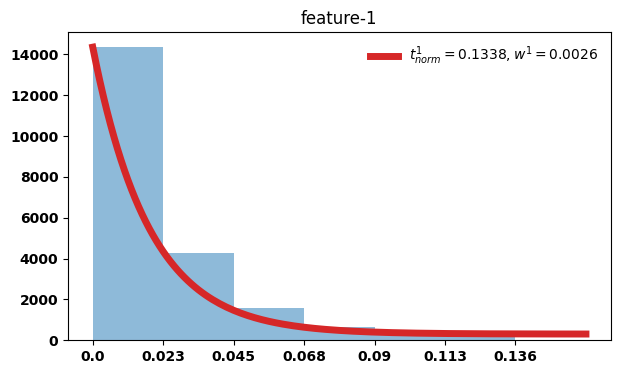

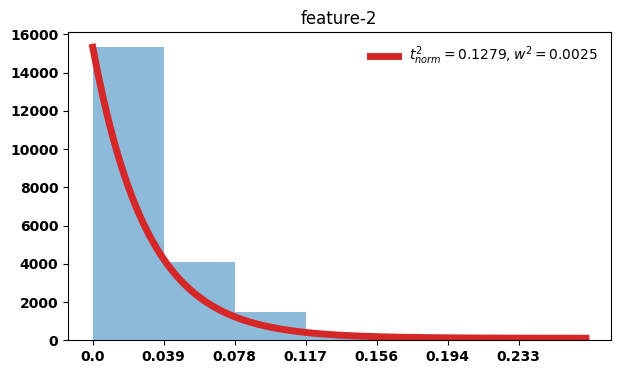

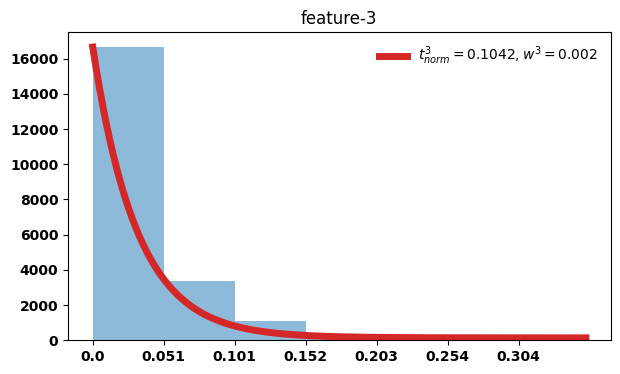

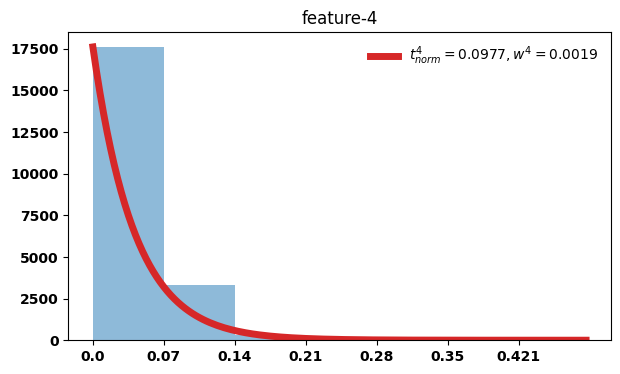

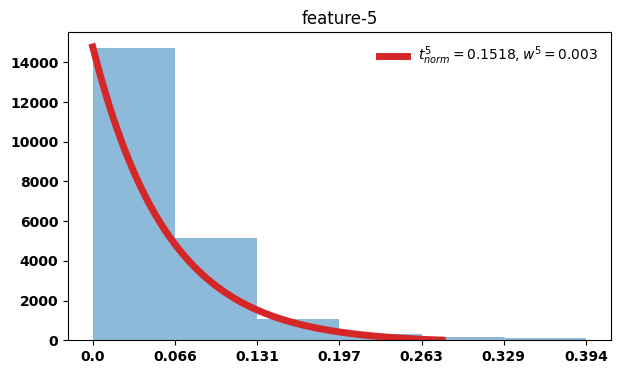

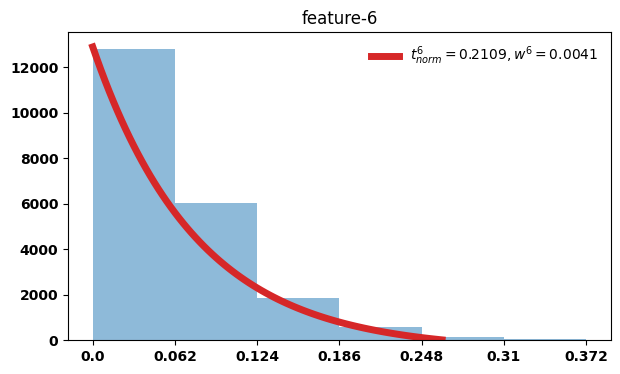

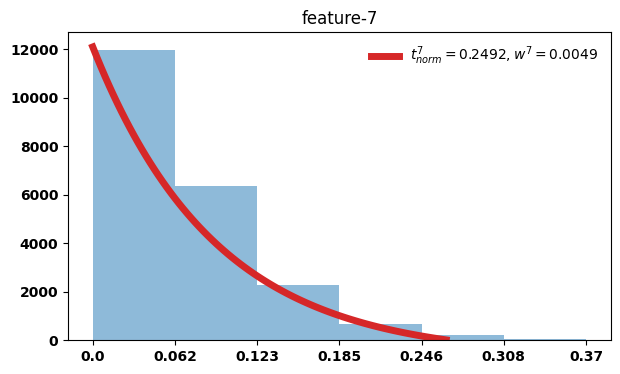

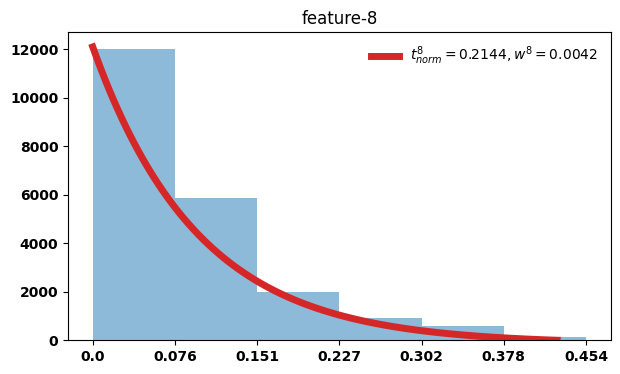

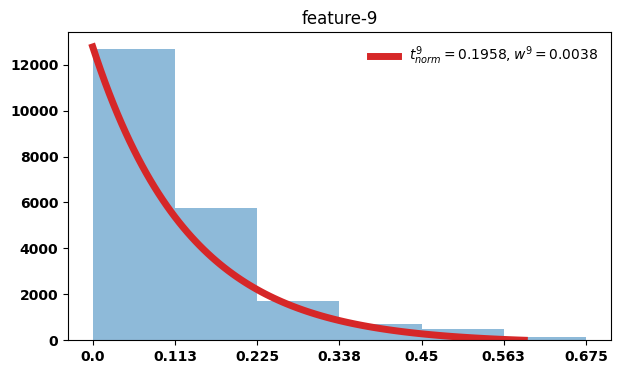

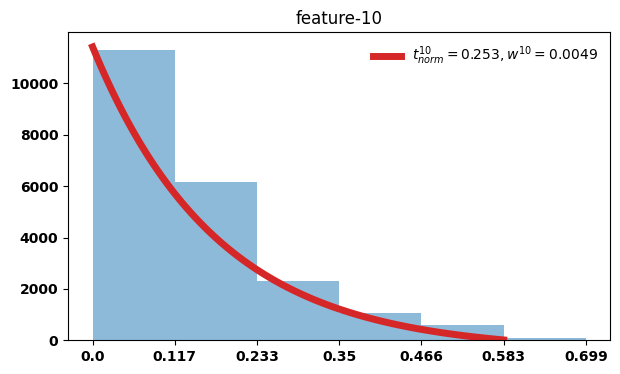

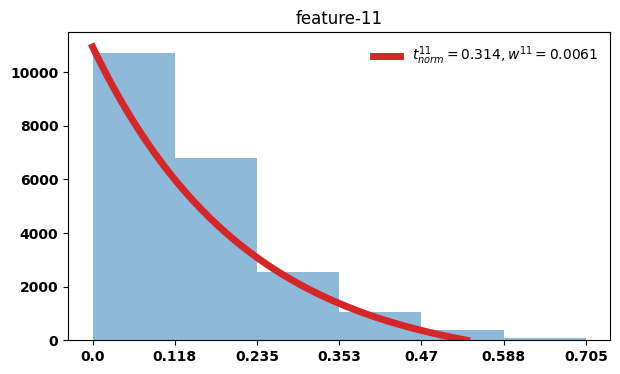

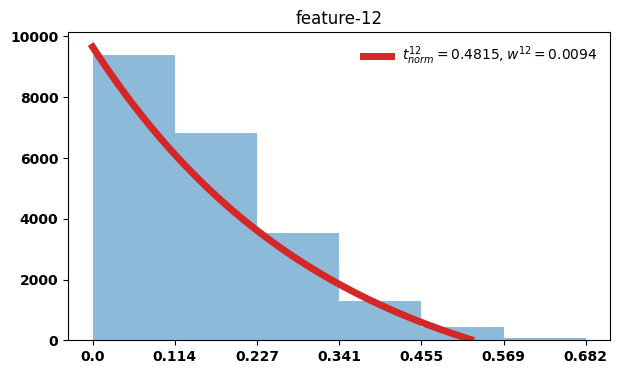

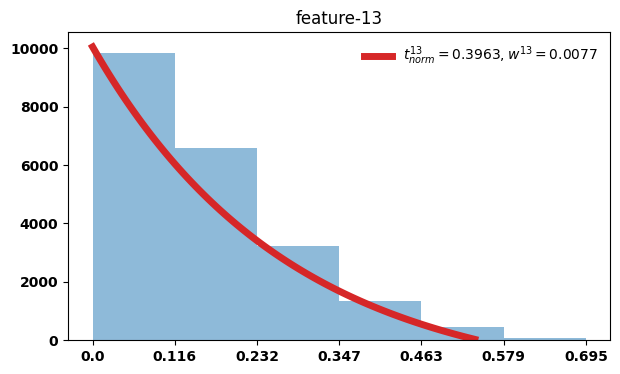

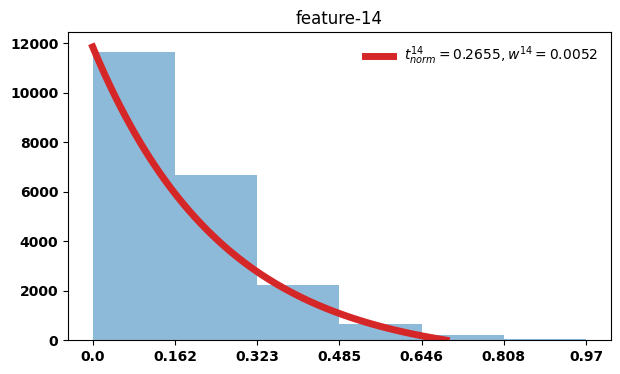

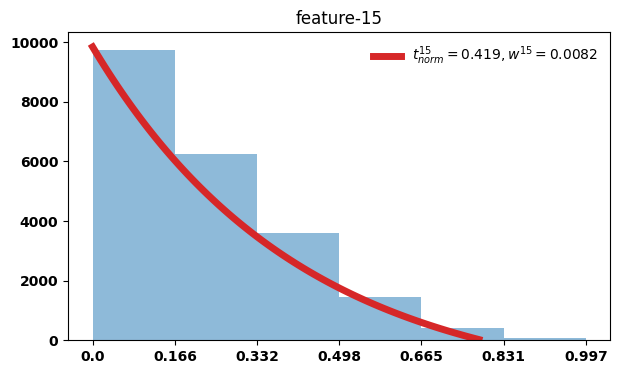

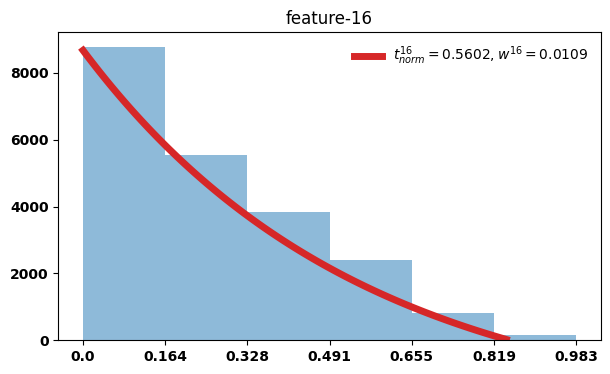

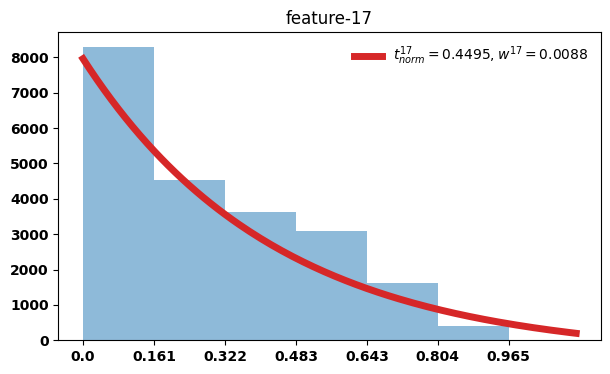

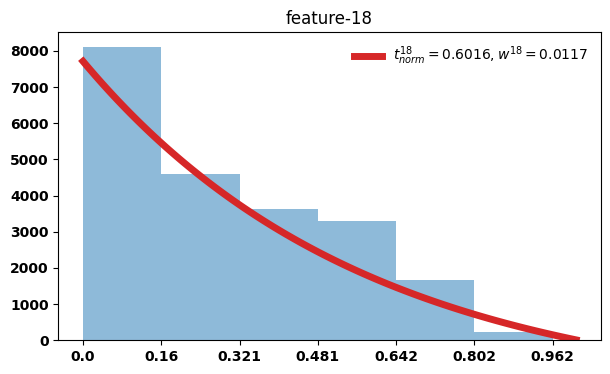

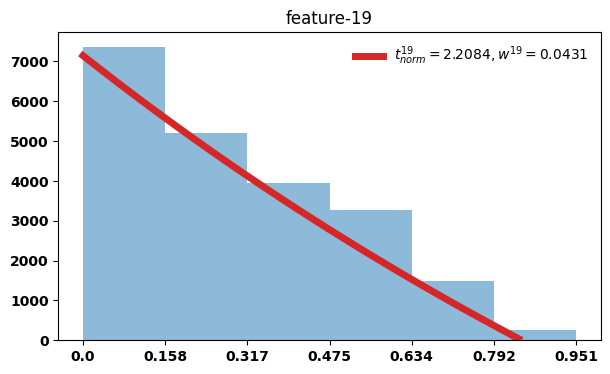

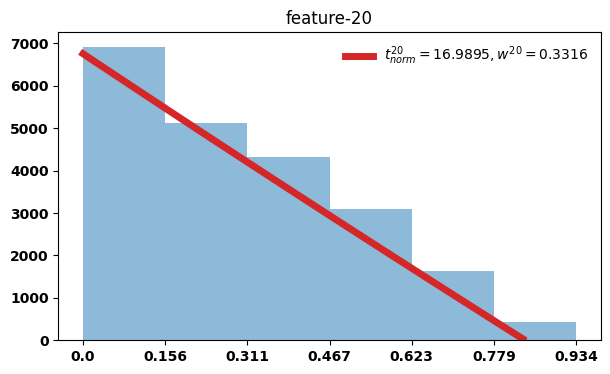

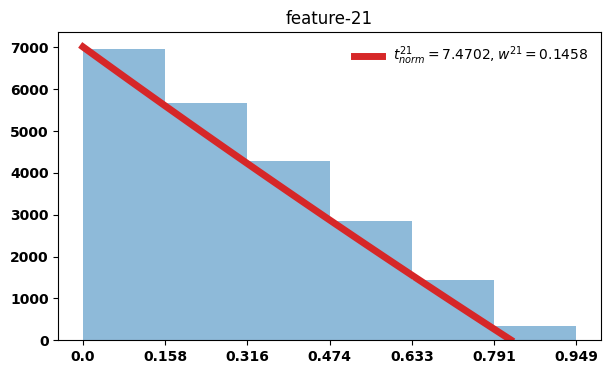

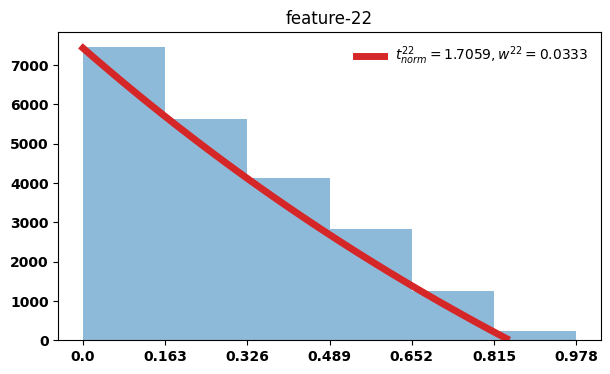

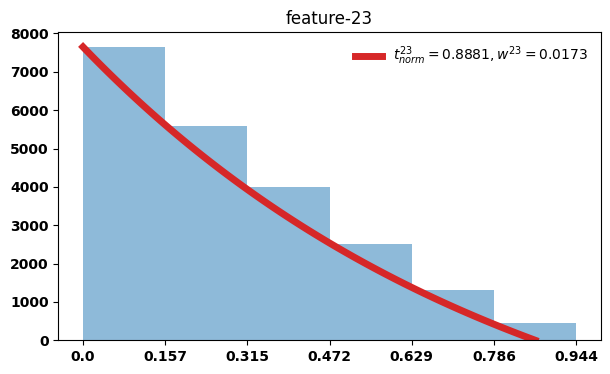

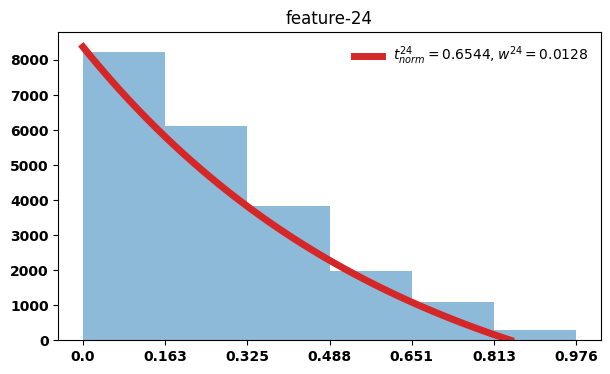

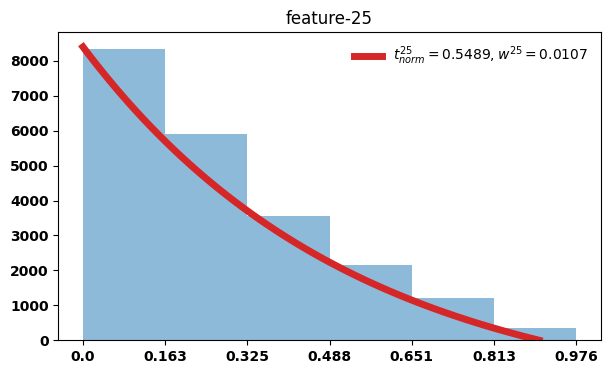

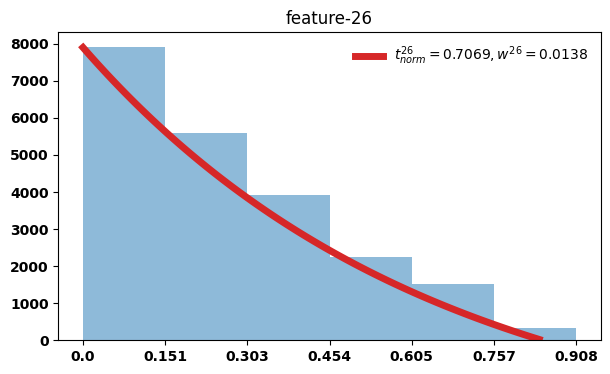

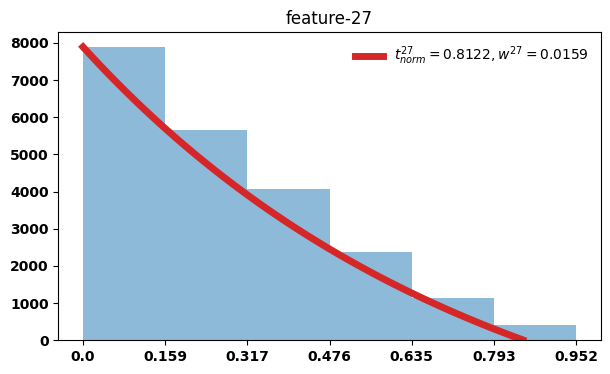

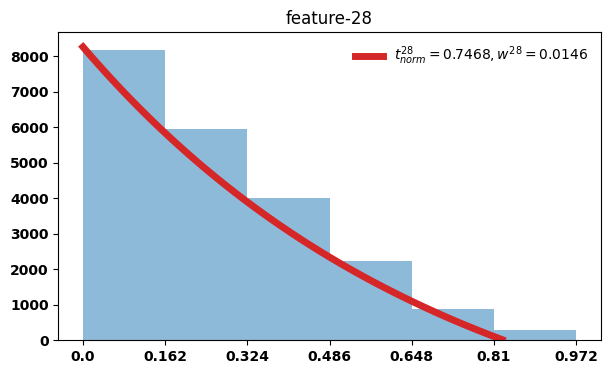

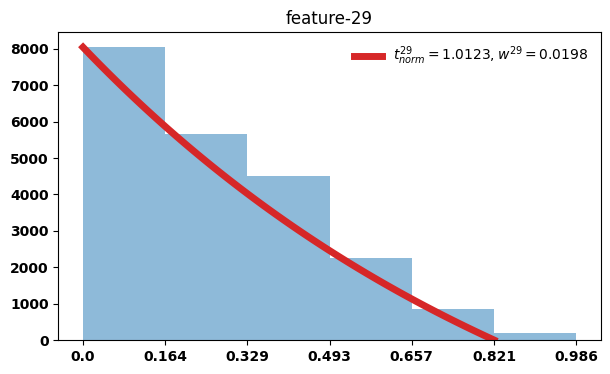

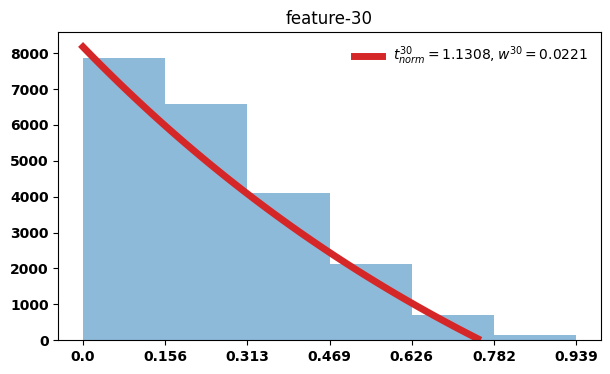

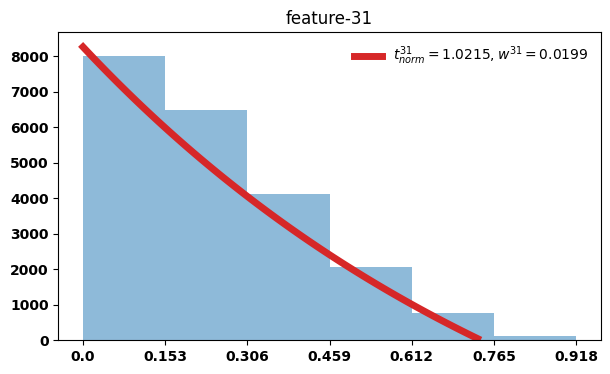

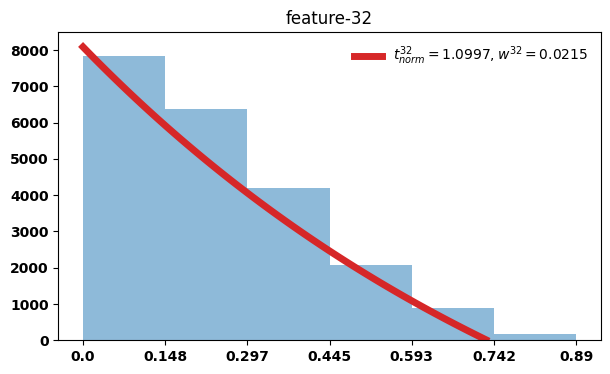

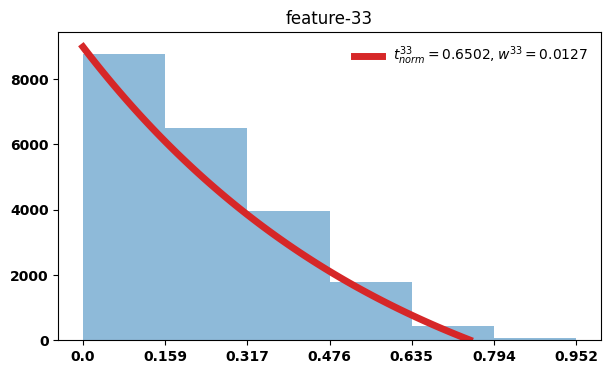

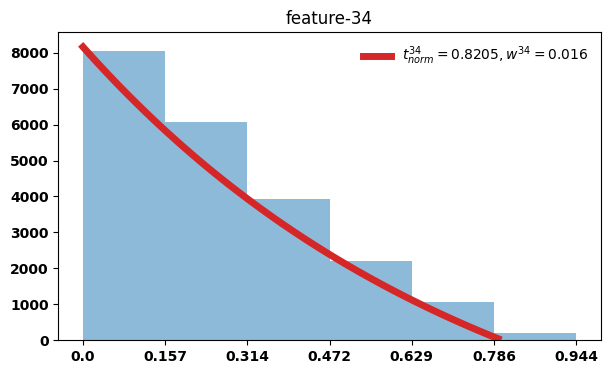

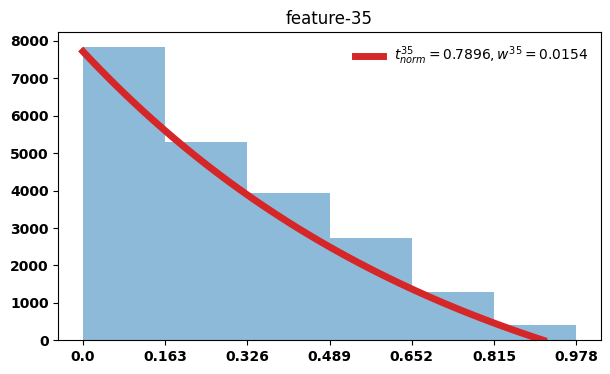

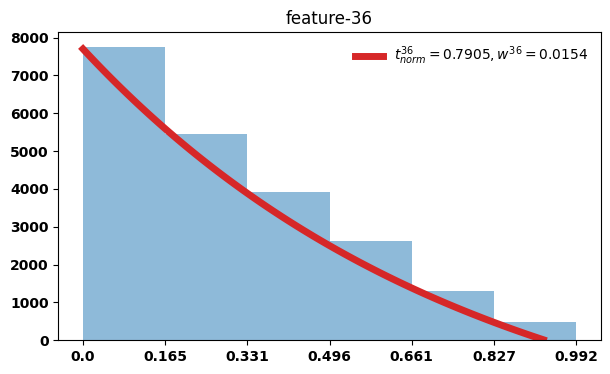

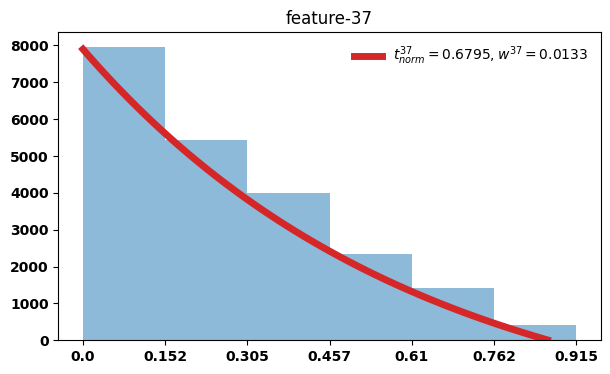

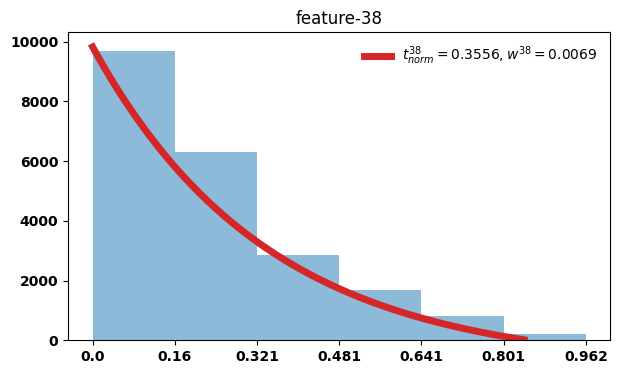

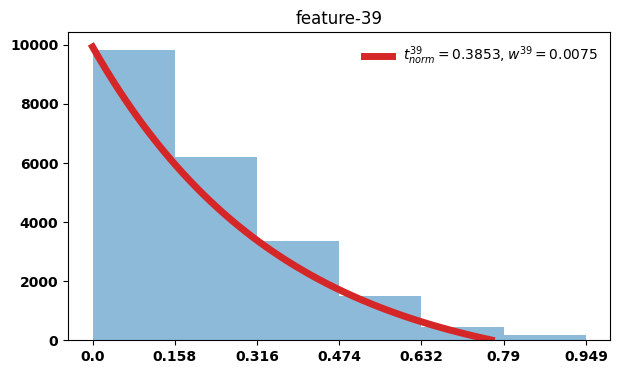

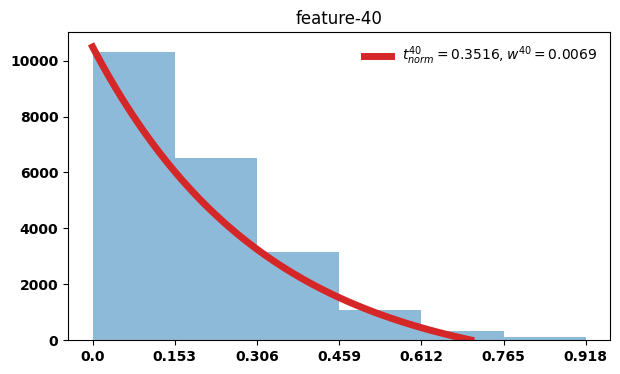

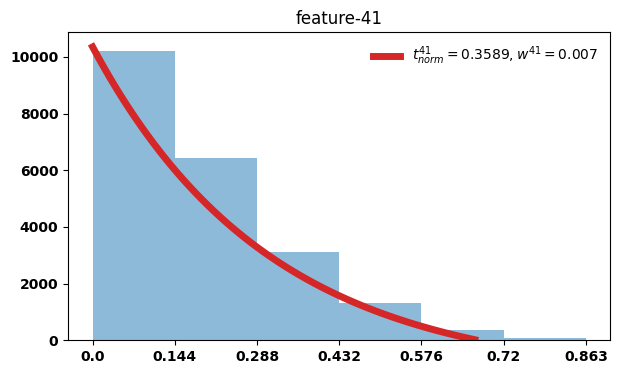

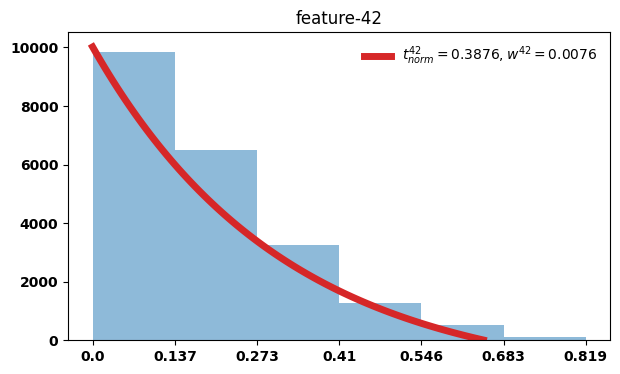

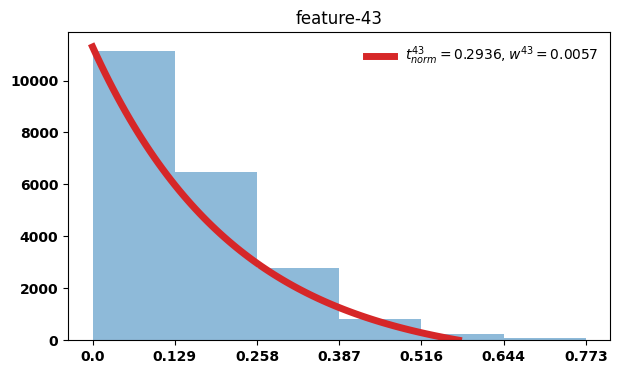

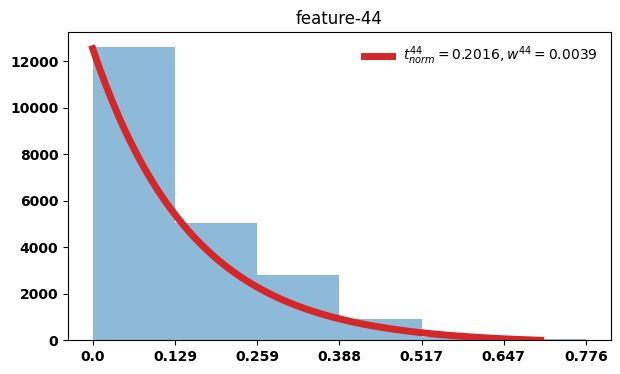

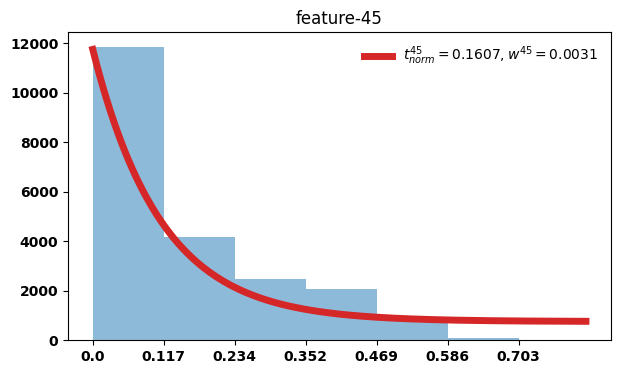

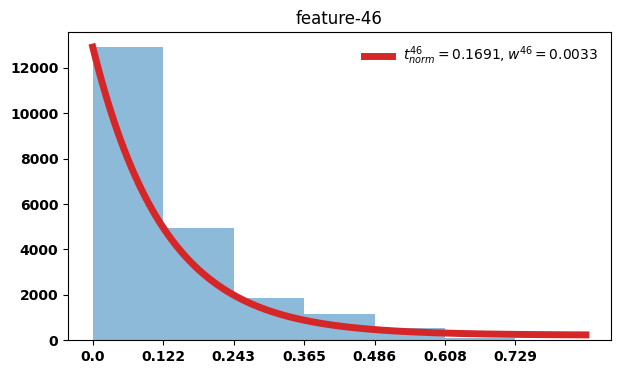

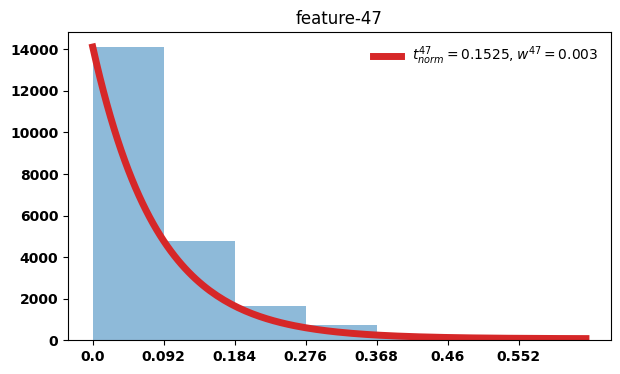

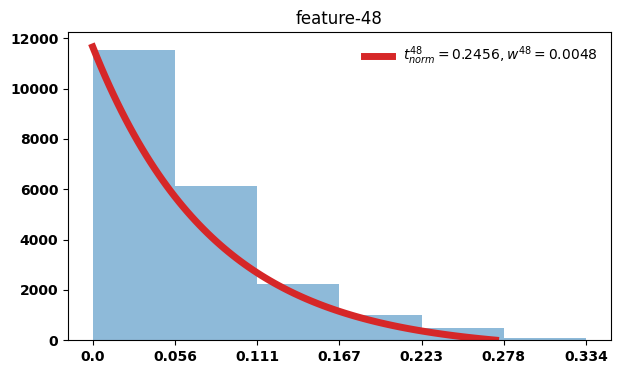

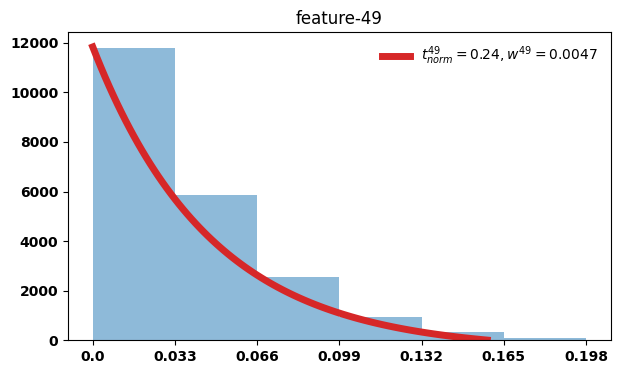

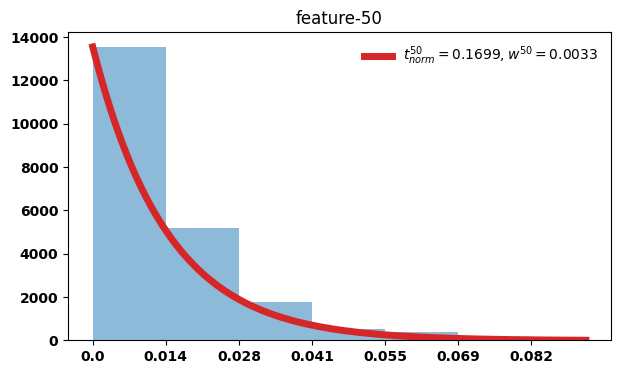

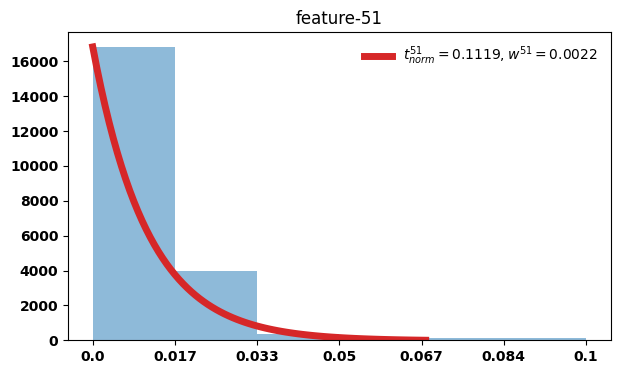

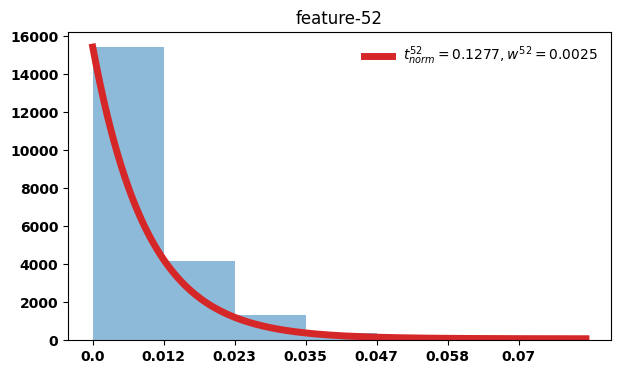

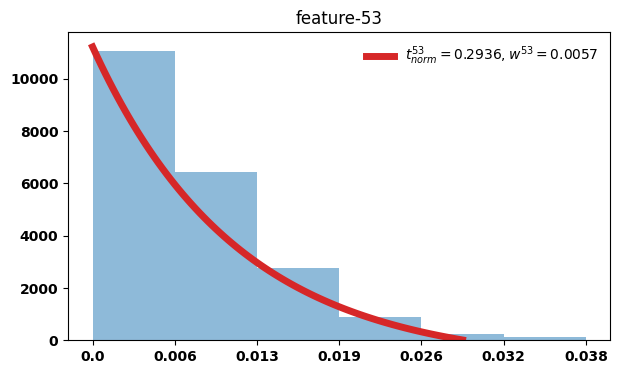

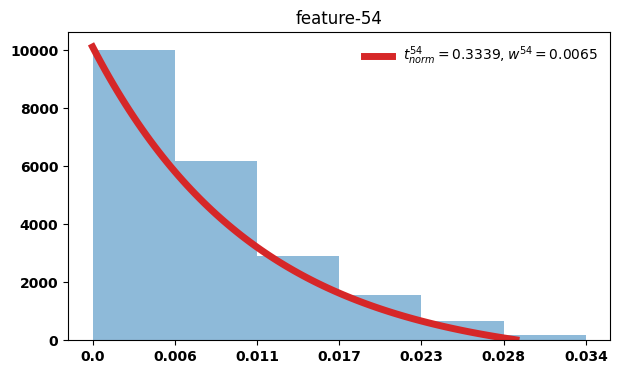

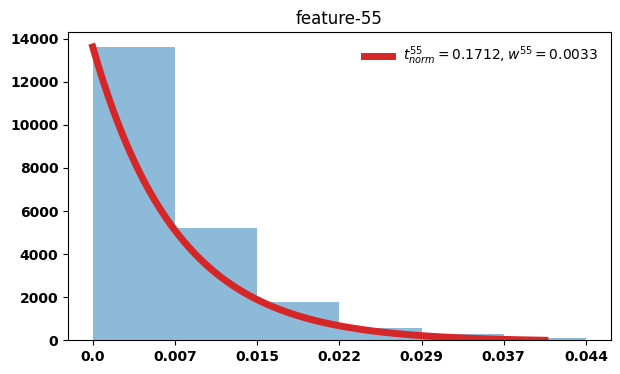

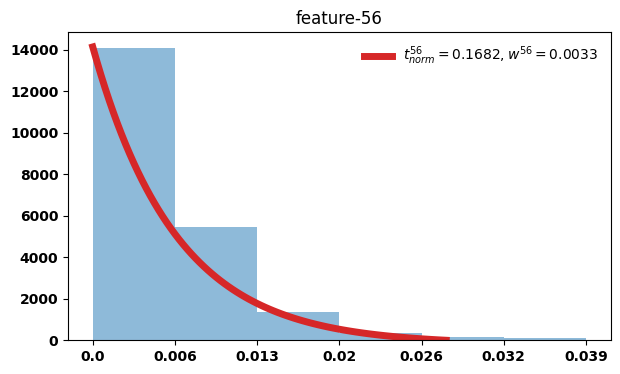

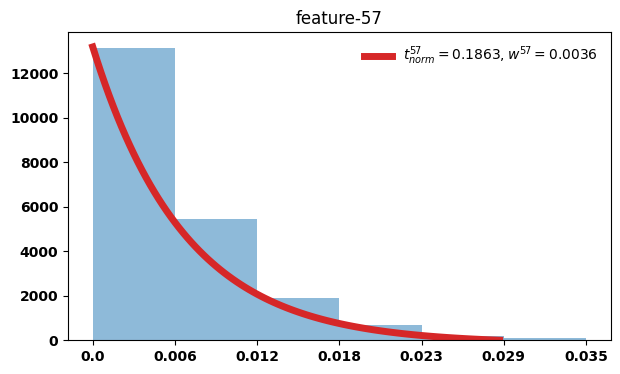

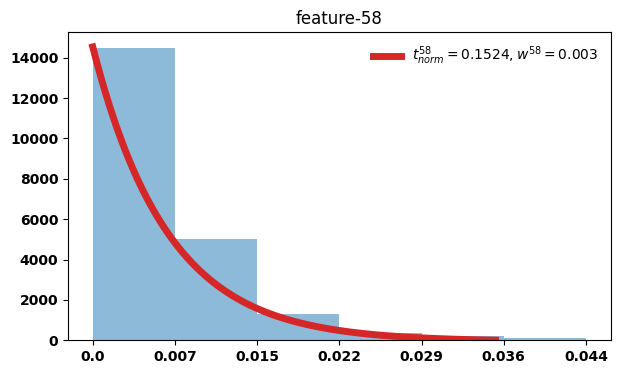

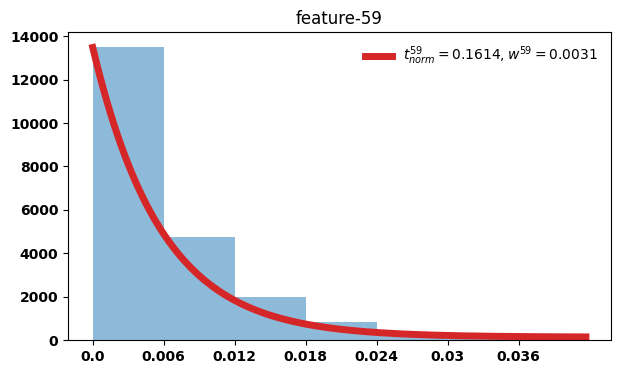

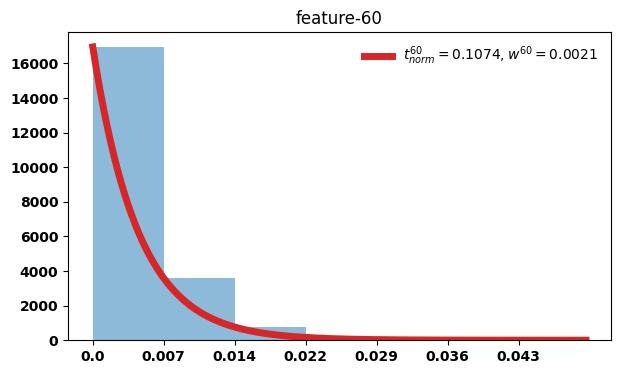

In [5]:
# To disable the visualization pass: is_plot=False

scales, weights, d_maxs, aa, cc, inits = calc_params(X, num_bins=6, is_plot=True)

Computing dissimilarity between any two points

In [6]:
# proposed dissimilarity function

def proposed_dist_measure(x, y):
    return np.sum( weights * ( 1 - np.exp( -np.abs(x - y) / d_maxs ) ) )

In [7]:
# computing the distance between fifth and tenth points of a dataset X

x_i = X[5]
x_j = X[10]

proposed_dist_measure(x_i, x_j)

0.25285340256202593

Computing distance matrix (if required)

In [8]:
DM_prop = pairwise_distances(X, metric=proposed_dist_measure)

In [9]:
# defining affinity function that will return the proposed distance matrix for the given dataset

def proposed_dist_affinity(X):
    return DM_prop

Performing agglomerative clustering using the proposed distance measure

In [10]:
agg_clustering = AgglomerativeClustering(n_clusters=K, affinity=proposed_dist_affinity, linkage='average').fit(X)
pred_labels = agg_clustering.labels_    # predicted labels

ari = adjusted_rand_score(lab, pred_labels)

'ARI: ' + str(round(ari, 4))

'ARI: 0.0963'